## DQN algorithm: Double DQN

In [9]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  def __init__(self):
    env = gym.make('Pendulum-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
  
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
    
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step(action)
    done = terminated or truncated
    self.step_n += 1
    if self.step_n >= 200:
      done = True
    return state, reward, done, info 
  
env = MyWrapper()
env.reset()

array([-0.40857336,  0.9127255 , -0.05397645], dtype=float32)

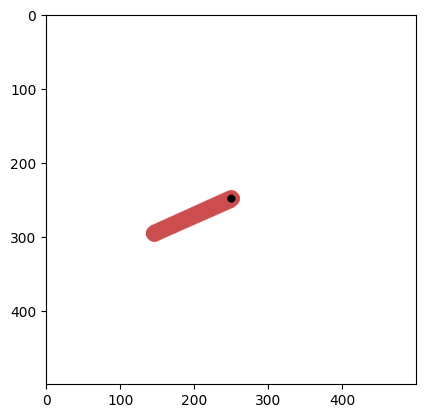

In [10]:
from matplotlib import pyplot as plt

%matplotlib inline

# 打印游戏
def show():
  plt.imshow(env.render())
  plt.show()
  
show()

In [11]:
# 测试游戏环境
# code changed

In [12]:
import torch

# code changed -----------------------------
# 计算动作模型，也是真正要用的模型
model = torch.nn.Sequential(
  torch.nn.Linear(3, 128),
  torch.nn.ReLU(),
  torch.nn.Linear(128,11),
)

# 经验网络，用于评估一个状态分数
next_model = torch.nn.Sequential(
  torch.nn.Linear(3, 128),
  torch.nn.ReLU(),
  torch.nn.Linear(128, 11),
)

# 把model的参数赋值给next_model
next_model.load_state_dict(model.state_dict())
# code chang end -----------------------------

model, next_model

(Sequential(
   (0): Linear(in_features=3, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=11, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=3, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=11, bias=True)
 ))

In [8]:
import random

# 得到一个动作
def get_action(state):
  # 走神经网络，得到一个动作
  state = torch.FloatTensor(state).reshape(1, 3)
  action = model(state).argmax().item()
  
  if random.random() < 0.01:
    action = random.choice(range(11))
    
  # 离散动作连续化
  action_c = action
  action_c /= 10
  action_c *= 4
  action_c -= 2
  
  return action, action_c

get_action([0.29292667, 0.9561349, 1.0957013])

(9, 1.6)

In [13]:
#样本池
datas = []


#向样本池中添加N条数据,删除M条最古老的数据
def update_data():
  old_count = len(datas)

  #玩到新增了N个数据为止
  while len(datas) - old_count < 200:
    #初始化游戏
    state = env.reset()

    #玩到游戏结束为止
    over = False
    while not over: 
      # code changed ----------------------------
      #根据当前状态得到一个动作
      action, action_c = get_action(state)

      #执行动作,得到反馈
      next_state, reward, over, _ = env.step([action_c])

      #记录数据样本
      datas.append((state, action, reward, next_state, over))

      #更新游戏状态,开始下一个动作
      state = next_state

  update_count = len(datas) - old_count
  drop_count = max(len(datas) - 5000, 0)

  #数据上限,超出时从最古老的开始删除
  while len(datas) > 5000:
    datas.pop(0)

  return update_count, drop_count
# code change end --------------------------

update_data(), len(datas)

((200, 0), 200)

In [14]:
# 获取一批数据样本
def get_sample():
  # 从样本池中采样
  samples = random.sample(datas, 64)
  
  # [b, 3]
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)
  # [b, 1]
  action = torch.LongTensor([i[1] for i in samples]).reshape(-1, 1)
  # [b, 1]
  reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
  # [b, 3]
  next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 3)
  # [b, 1]
  over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)
  
  return state, action, reward, next_state, over

state, action, reward, next_state, over = get_sample()

state, action, reward, next_state, over

C:\Users\fanyu\AppData\Local\Temp\ipykernel_2660\3064498686.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)


(tensor([[ 8.7158e-01,  4.9025e-01, -5.6900e+00],
         [-9.3521e-02, -9.9562e-01, -8.0000e+00],
         [ 7.0935e-01, -7.0486e-01, -6.6453e+00],
         [-6.5148e-01, -7.5867e-01, -8.0000e+00],
         [ 9.0046e-01, -4.3493e-01, -6.0792e+00],
         [ 2.4738e-01, -9.6892e-01, -2.4405e+00],
         [-4.3156e-01,  9.0209e-01, -7.7260e+00],
         [ 8.3696e-01,  5.4726e-01, -5.7349e+00],
         [-3.5746e-01,  9.3393e-01, -7.6182e+00],
         [ 9.8192e-01,  1.8928e-01, -5.5765e+00],
         [ 9.5452e-01, -2.9815e-01, -5.8476e+00],
         [-9.6296e-01, -2.6965e-01, -8.0000e+00],
         [-2.7552e-01,  9.6129e-01, -7.5105e+00],
         [ 8.5649e-01, -5.1617e-01, -6.1840e+00],
         [ 9.9390e-01, -1.1027e-01, -5.6946e+00],
         [ 1.5333e-01,  9.8818e-01, -6.9146e+00],
         [-1.9062e-01,  9.8166e-01, -7.4108e+00],
         [ 8.3603e-01, -5.4869e-01, -6.2449e+00],
         [ 3.4628e-02,  9.9940e-01, -7.0881e+00],
         [ 9.8486e-01,  1.7336e-01, -5.5846e+00],


In [15]:
def get_value(state, action):
  # 使用状态计算出动作的logits
  # [b, 3] -> [b, 11]
  value = model(state)
  
  #根据实际使用的action取出每一个值
  #这个值就是模型评估的在该状态下,执行动作的分数
  #在执行动作前,显然并不知道会得到的反馈和next_state
  #所以这里不能也不需要考虑next_state和reward
  #[b, 11] -> [b, 1]
  value = value.gather(dim=1, index=action)
  return value

get_value(state, action).shape

torch.Size([64, 1])

In [16]:
def get_target(reward, next_state, over):
  #上面已经把模型认为的状态下执行动作的分数给评估出来了
  #下面使用next_state和reward计算真实的分数
  #针对一个状态,它到底应该多少分,可以使用以往模型积累的经验评估
  #这也是没办法的办法,因为显然没有精确解,这里使用延迟更新的next_model评估

  #使用next_state计算下一个状态的分数
  #[b, 3] -> [b, 11]
  with torch.no_grad():
    target = next_model(next_state)
    
  """code changed here"""
  #取所有动作中分数最大的
  #[b, 11] -> [b, 1]
  # target = target.max(dim=1)[0]
  
  # model 计算下一个状态的分数
  # [b, c] -> [b, 11]
  with torch.no_grad():
    model_target = model(next_state)
  
  # 取分数最高的下标
  # [b, 11] -> [b, 1]
  model_target = model_target.max(dim=1)[1]
  model_target = model_target.reshape(-1, 1)
  
  # 以这个下标取next_value中的值
  # [b, 11] -> [b]
  target = target.gather(dim=1, index=model_target)
  """code change end """
  # 下一个状态的分数乘以一个系数,相当于权重
  target *= 0.98
  
  #如果next_state已经游戏结束,则next_state的分数是0
  #因为如果下一步已经游戏结束,显然不需要再继续玩下去,也就不需要考虑next_state了.
  #[b, 1] * [b, 1] -> [b, 1]
  target *= (1 - over)
  
  #加上reward就是最终的分数
  #[b, 1] + [b, 1] -> [b, 1]
  target += reward
  
  return target

get_target(reward, next_state, over).shape

torch.Size([64, 1])

In [17]:
from IPython import display

def test(play):
  #初始化游戏
  state = env.reset()
  
  #记录反馈值的和,这个值越大越好
  reward_sum = 0
  
  #玩到游戏结束为止
  over = False
  while not over:
    #根据当前状态得到一个动作
    _, action_c = get_action(state)
    
    #执行动作,得到反馈
    state, reward, over, _ = env.step([action_c])
    reward_sum += reward
    
    # 打印动画
    if play and random.random() < 0.2: # 跳帧
      display.clear_output(wait=True)
      show()
      
  return reward_sum

test(play=False)

-1531.6485652945416

In [18]:
def train():
  model.train()
  optimizer = torch.optim.Adam(model.parameters(), lr=2e-2)
  loss_fn = torch.nn.MSELoss()
  
  # 训练N次
  for epoch in range(200):
    # 更新N条数据
    update_count, drop_count = update_data()
    
    # 每次更新过数据后，学习N次
    for i in range(200):
      # 采取一批数据
      state, action, reward, next_state, over = get_sample()
      
      # 计算一批样本的value和target
      value = get_value(state, action)
      target = get_target(reward, next_state, over)
      
      # 更新参数
      loss = loss_fn(value, target)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # 把model的参数复制给next_model
      if (i + 1) % 50 == 0:
        next_model.load_state_dict(model.state_dict())
    
    if epoch % 20 == 0:
      test_result = sum([test(play=False) for _ in range(20)]) / 20
      print(epoch, len(datas), update_count, drop_count, test_result)
      
train()

0 400 200 0 -1174.3260961051226
20 4400 200 0 -1419.3020415137034
40 5000 200 200 -361.42501719451695
60 5000 200 200 -676.8891907346687
80 5000 200 200 -264.8905294413507
100 5000 200 200 -214.46914348709862
120 5000 200 200 -194.50856084075485
140 5000 200 200 -566.5050777621585
160 5000 200 200 -681.6132215467053
180 5000 200 200 -200.37446486940198


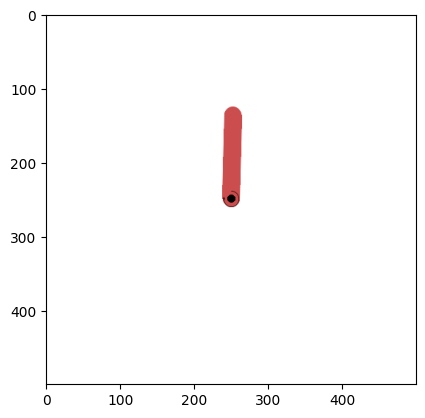

-127.17630353763506

In [19]:
test(play=True)